### 因子分析步骤
1. 对所给的数据样本进行标准化处理

2. 计算样本的相关矩阵R

3. 求相关矩阵R的特征值、特征向量

4. 根据系统要求的累积贡献度确定主因子的个数

5. 计算因子载荷矩阵A

6. 最终确定因子模型

In [1]:
import factor_analyzer

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from factor_analyzer import FactorAnalyzer

In [3]:
df = pd.read_csv('NYC_Bgrp_Geocoded.csv')

In [5]:
df.columns

Index(['geometry', 'tesctyscor', 'priority', 'core_m', 'asthma', 'area',
       'tc_gap', 'tes', 'geoid', 'total_pop', 'bgpopdense', 'healthnorm',
       'phys_hlth', 'child_perc', 'congressio', 'core_w', 'avg_temp', 'source',
       'treecanopy', 'pctpoc', 'seniorperc', 'unemplrate', 'dep_ratio',
       'state', 'pctpov', 'county', 'ment_hlth', 'tc_goal', 'medhhinc',
       'core_norm', 'popadjust', 'biome', 'ua_name', 'incorpname'],
      dtype='object')

### useful columns
1. 待补充贫困人口数据
2. pctpoc：有色人口百分比
3. unemplrate： 失业率
4. dep_ratio：(老人+孩子)/(18到64岁人口)
5. child_perc：块组内的孩子的百分比
6. seniorperc：区块组内的老年人百分比
7. avg_temp：炎热夏日区块组的平均温度
8. phys_hlth：区块组中人们自我报告的身体健康挑战（百分比）
9. asthma：街区组人员自我报告的哮喘挑战（百分比）
10. core_m：街区组中男性自我报告的男性冠心病（百分比）
11. core_w：街区组中女性自我报告的女性冠心病（百分比）

In [18]:
df_t = df[['pctpoc', 'unemplrate', 'dep_ratio', 'child_perc', 'seniorperc',
          'avg_temp', 'phys_hlth', 'asthma', 'core_m', 'core_w']]

In [19]:
df_t.isnull().sum()

pctpoc        0
unemplrate    0
dep_ratio     0
child_perc    0
seniorperc    0
avg_temp      0
phys_hlth     9
asthma        9
core_m        9
core_w        9
dtype: int64

In [20]:
df_t = df_t.dropna()

In [21]:
df_t.isnull().sum()

pctpoc        0
unemplrate    0
dep_ratio     0
child_perc    0
seniorperc    0
avg_temp      0
phys_hlth     0
asthma        0
core_m        0
core_w        0
dtype: int64

Bartlett's检验
p=0 拒绝原假设（原假设：相关性矩阵为单位矩阵，即对角线1，其它都为0），说明数据特征存在相关性，适合进行因子分析

In [22]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
 
chi_square_value, p_value = calculate_bartlett_sphericity(df_t)
chi_square_value, p_value

(39160.141474716256, 0.0)

KMO检验 取值0-1，越接近1特征间相关性越强，一般需要大于0.6开始因子分析，此处>0.6, 适用因子分析

In [23]:
#KMO检验
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_t)
kmo_model

0.7482047555634286

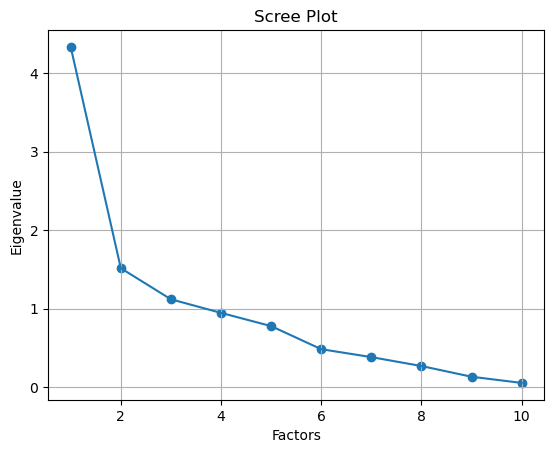

In [25]:
faa = FactorAnalyzer(25,rotation=None)
faa.fit(df_t)
 
ev,v=faa.get_eigenvalues()

plt.scatter(range(1, df_t.shape[1] + 1), ev)
plt.plot(range(1, df_t.shape[1] + 1), ev)
 
plt.title("Scree Plot")  
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
 
plt.grid()
plt.show()

根据特征可以判断Factors数量3或4个即可，为示意此处选择两个

In [33]:
# 选择2个factor
faa_two = FactorAnalyzer(2,rotation='varimax')
faa_two.fit(df_t)

FactorAnalyzer(n_factors=2, rotation='varimax', rotation_kwargs={})

In [34]:
# 每个变量解释方差
pd.DataFrame(faa_two.get_communalities(),index=df_t.columns)

,0
pctpoc,0.515799
unemplrate,0.172148
dep_ratio,0.262560
child_perc,0.199762
seniorperc,1.013073
avg_temp,0.034328
phys_hlth,0.832993
asthma,0.513778
core_m,0.878837
core_w,0.835434


In [37]:
# 因子成分
pd.DataFrame(faa_two.loadings_,index=df_t.columns)

,0,1
pctpoc,0.709899,-0.108825
unemplrate,0.414811,-0.008928
dep_ratio,0.090217,0.504402
child_perc,0.432973,-0.110890
seniorperc,-0.265271,0.970929
avg_temp,0.184605,-0.015767
phys_hlth,0.897130,0.167781
asthma,0.715816,0.037224
core_m,-0.935965,0.052975
core_w,-0.913936,-0.012439


In [38]:
# 关注第二行 第三行 分别为 方差贡献率 累积方差贡献率
faa_two.get_factor_variance()

(array([4.00462157, 1.25409029]),
 array([0.40046216, 0.12540903]),
 array([0.40046216, 0.52587119]))

In [39]:
# 取贡献率绝对值，探究因子和feature相关性
df1 = pd.DataFrame(np.abs(faa_two.loadings_),index=df_t.columns)
print(df1)

                   0         1
pctpoc      0.709899  0.108825
unemplrate  0.414811  0.008928
dep_ratio   0.090217  0.504402
child_perc  0.432973  0.110890
seniorperc  0.265271  0.970929
avg_temp    0.184605  0.015767
phys_hlth   0.897130  0.167781
asthma      0.715816  0.037224
core_m      0.935965  0.052975
core_w      0.913936  0.012439


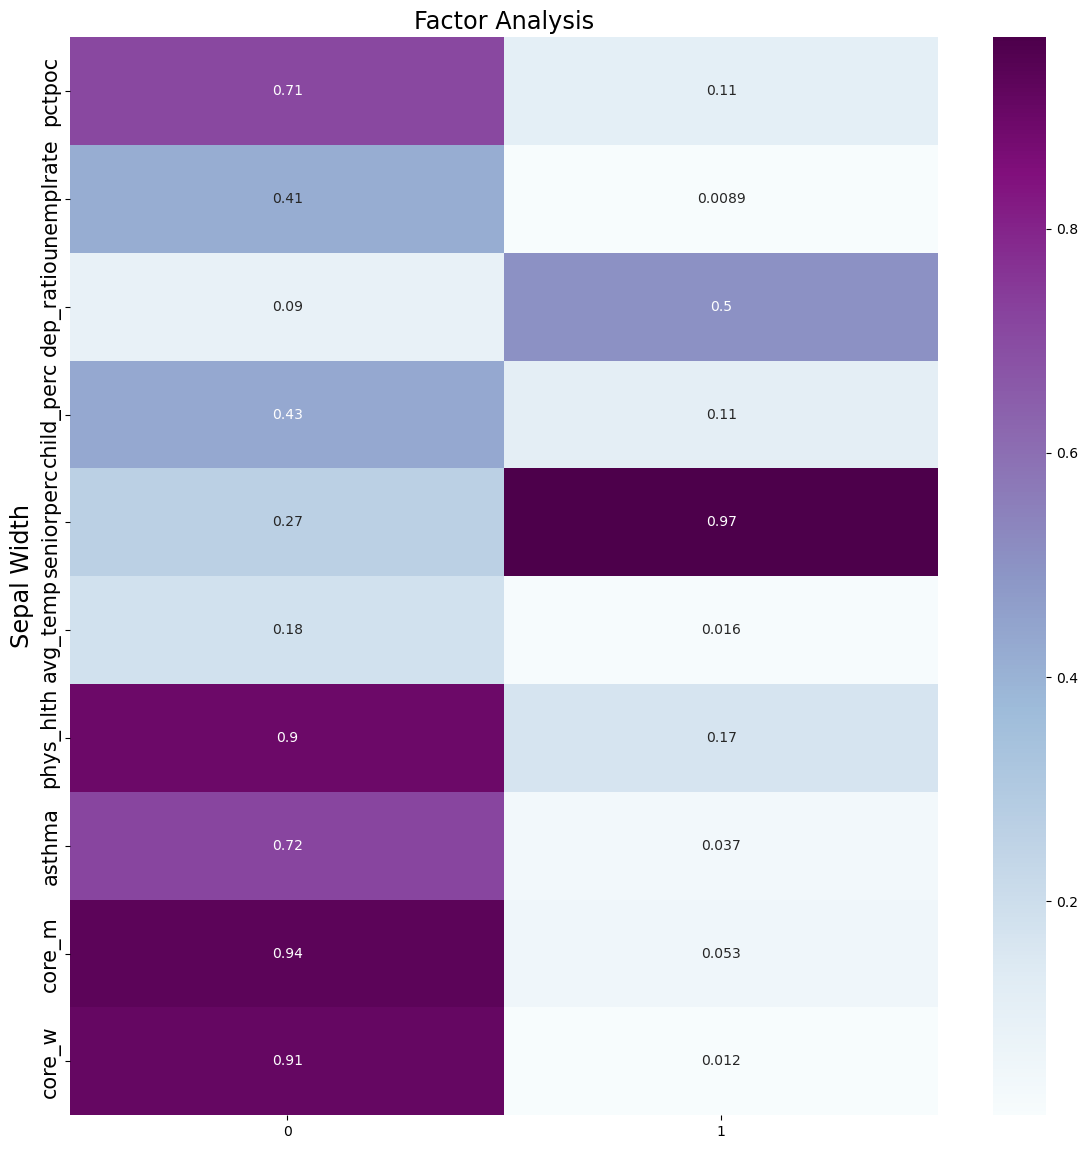

In [40]:
# 绘图
 
plt.figure(figsize = (14,14))
ax = sns.heatmap(df1, annot=True, cmap="BuPu")

ax.yaxis.set_tick_params(labelsize=15)
plt.title("Factor Analysis", fontsize="xx-large")

plt.ylabel("Sepal Width", fontsize="xx-large")

plt.show()

In [41]:
df2 = pd.DataFrame(faa_two.transform(df_t)) # 将原数据转化为两因子数据

In [42]:
df2.head()

,0,1
0,-0.554574,-0.212328
1,-0.639496,0.388793
2,-0.462290,-1.138056
3,-0.681161,1.128788
4,-0.812016,3.008723
